In [23]:
import os
import time

import numpy as np
import scipy as sp
from scipy import stats as sps
from scipy import linalg
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
devices = ['cuda:0', 'cuda:2', 'cuda:3', 'cuda:5']
device = devices[1]
#device = 'cpu'

## Dataset loader class for torch

In [346]:
class Dataset():
    def __init__(self, data_split):
        data = np.load(data_split,allow_pickle=True).item()
        self.supervoxel_interp = data['supervoxel_interp']
        self.Y = data['Y'] #/100 if not zscoring
        self.Y = sps.zscore(self.Y, nan_policy='omit')
        #self.Y[:,0] = ndimage.gaussian_filter1d(self.Y[:,0],sigma=1)
        #self.Y[:,1] = ndimage.gaussian_filter1d(self.Y[:,1],sigma=1)
    def __getitem__(self, index):
        supervoxel = self.supervoxel_interp[index,:]
        y = self.Y[index,:]
        return supervoxel, y
    def __len__(self):
        return len(self.supervoxel_interp)
    def get_random_item(self):
        n_samples = len(self.Y)
        rand_idx = np.random.randint(n_samples)
        return self.supervoxel_interp[rand_idx,:], self.Y[rand_idx,:]

## Data set io and data loader initializer

In [347]:
# Constants for now but will be a tested hyperparameter ...
ALPHA = 0.01

# Get the data and initialize the dataloader
train_dataset = Dataset('/mnt/fs4/minseung/deepfly/data/prelim/train_data_layer_no_fwd_clip23.npy')
test_dataset = Dataset('/mnt/fs4/minseung/deepfly/data/prelim/test_data_layer_no_fwd_clip23.npy')
BATCH_SIZE = train_dataset.supervoxel_interp.shape[0]
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False)

In [27]:
train_dataset.supervoxel_interp.shape

(27410, 2000)

# Simple (?) 3-layer neural network, rotational (scaled * 100)

In [37]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.linear1 = nn.Linear(2000, 256)

        self.dropout1 = nn.Dropout(p=.2)

        self.linear2 = nn.Linear(256, 128)
        
        self.linear3 = nn.Linear(128, 2)
        
    def forward(self, x):
        
        x = F.relu(self.linear1(x))
        
        x = self.dropout1(x)

        x = F.relu(self.linear2(x))
        
        x = self.linear3(x)
        
        return x

model = Model()
model.train()
    
# Define the loss function as MSE loss
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

# Define the optimizer with a learning rate
#optimizer = optim.Adam(model.parameters(), lr=ALPHA)
optimizer = optim.Adam(model.parameters(), lr=ALPHA, weight_decay=1e-5)
model = model.to(device)

## Train the fucking model

In [38]:
start_time = time.time()

# Constant for now but will be a hyperparameter
N_EPOCHS = 125
cost_cache = []

for epoch in range(N_EPOCHS): 
    epoch_start_time = time.time()
    
    for i, (supervoxel, y) in enumerate(train_loader, 0):
        
        supervoxel = supervoxel.float().to(device)
        y = y.float().to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propogation
        outputs = model.forward(supervoxel)
        
        # calculate the loss
        loss = criterion(outputs, y)
        
        # backpropogation + cache grads + update parameters
        loss.backward()
        optimizer.step()

        # print statistics
        cost = loss.item()
        cost_cache.append(cost)
        if epoch % 10 == 0 and i % 100 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))
            print("--- Epoch: %s seconds ---" % (time.time() - epoch_start_time))
            
print("--- %s seconds ---" % (time.time() - start_time))

Epoch:0, Iteration: 0, training cost = 1.006888508796692
--- Epoch: 1.4745233058929443 seconds ---
Epoch:10, Iteration: 0, training cost = 0.9265821576118469
--- Epoch: 0.8577275276184082 seconds ---
Epoch:20, Iteration: 0, training cost = 0.7995762228965759
--- Epoch: 0.8924672603607178 seconds ---
Epoch:30, Iteration: 0, training cost = 0.6423543691635132
--- Epoch: 0.6531543731689453 seconds ---
Epoch:40, Iteration: 0, training cost = 0.461442768573761
--- Epoch: 0.6104917526245117 seconds ---
Epoch:50, Iteration: 0, training cost = 0.333538293838501
--- Epoch: 0.7518985271453857 seconds ---
Epoch:60, Iteration: 0, training cost = 0.25318560004234314
--- Epoch: 0.8873951435089111 seconds ---
Epoch:70, Iteration: 0, training cost = 0.20191502571105957
--- Epoch: 0.7692804336547852 seconds ---
Epoch:80, Iteration: 0, training cost = 0.17176054418087006
--- Epoch: 0.7084395885467529 seconds ---
Epoch:90, Iteration: 0, training cost = 0.14838917553424835
--- Epoch: 0.6533834934234619 se

## Predict the training data and compute the error

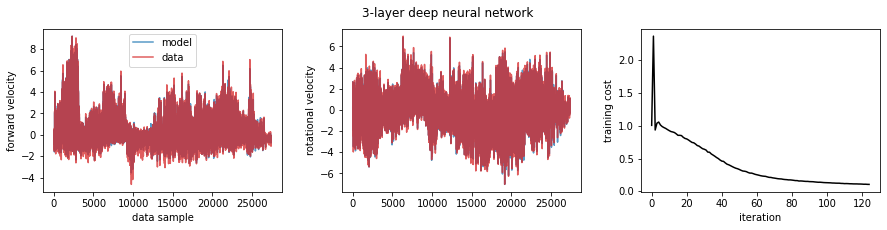

training mean-squared error: 0.001


In [39]:
# Turn off dropout in the model
model.eval()

# Get the outputs from the test data.
predictions = []

for data in train_loader:
    supervoxel,y = data
    supervoxel = supervoxel.float().to(device)
    prediction = model(supervoxel).cpu().detach().numpy()
    predictions.append(prediction)

predictions = np.vstack(predictions)

fig,ax = plt.subplots(1,3,figsize=(15,3))
fig.subplots_adjust(wspace=.25)
ax[0].plot(predictions[:,0],c='C0',alpha=.75,label='model')
ax[0].plot(train_dataset.Y[:,0],c='C3',alpha=.75,label='data')
ax[0].set_xlabel('data sample')
ax[0].set_ylabel('forward velocity')
ax[0].legend()

ax[1].plot(predictions[:,1],c='C0',alpha=.75)
ax[1].plot(train_dataset.Y[:,1],c='C3',alpha=.75)
ax[1].set_ylabel('rotational velocity')

ax[2].plot(cost_cache,c='k')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('training cost')

plt.suptitle('3-layer deep neural network')
plt.show()

# Compute the error and print it out.
training_error = 1 / np.product(predictions.shape) * linalg.norm(predictions - train_dataset.Y)
print("training mean-squared error: %.3f"%training_error)

## Same thing but for for test data

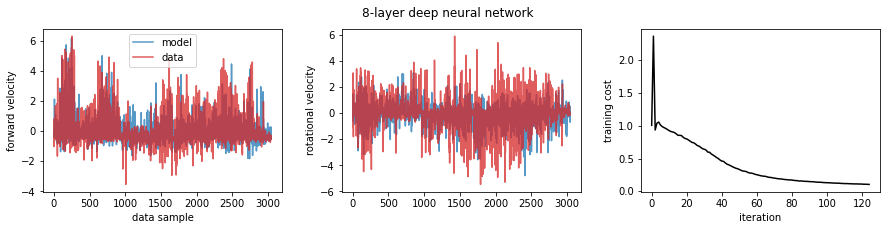

testing mean-squared error: 0.013


In [40]:
# Get the outputs from the test data.
predictions = []

for data in test_loader:
    supervoxel,y = data
    supervoxel = supervoxel.float().to(device)
    #supervoxel.to('cpu')
    
    prediction = model(supervoxel).to('cpu').detach().numpy()
    #prediction = model(float(supervoxel))

    predictions.append(prediction)

predictions = np.vstack(predictions)

fig,ax = plt.subplots(1,3,figsize=(15,3))
fig.subplots_adjust(wspace=.25)
ax[0].plot(predictions[:,0],c='C0',alpha=.75,label='model')
ax[0].plot(test_dataset.Y[:,0],c='C3',alpha=.75,label='data')
ax[0].set_xlabel('data sample')
ax[0].set_ylabel('forward velocity')
ax[0].legend()

ax[1].plot(predictions[:,1],c='C0',alpha=.75)
ax[1].plot(test_dataset.Y[:,1],c='C3',alpha=.75)
ax[1].set_ylabel('rotational velocity')

ax[2].plot(cost_cache,c='k')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('training cost')

plt.suptitle('8-layer deep neural network')
plt.show()

# Compute the error and print it out.
testing_error = (1 / np.product(predictions.shape)) * linalg.norm(predictions.ravel() - test_dataset.Y.ravel())
print("testing mean-squared error: %.3f"%testing_error)

# Backflow!

In [348]:
def paint_supervoxels_to_voxels_1_z_layer(supervoxel_activations, cluster_assignments_1d, vmax=None, ax=None):
    img = np.asarray([supervoxel_activations[svi] for svi in cluster_assignments_1d]).reshape((256,128)).T
    if ax is None:
        _,ax = plt.subplots()
    imshow = ax.imshow(img, vmin=None if vmax is None else -vmax, vmax=vmax, cmap='bwr')
    ax.axis('equal')
    return img,imshow

In [290]:
# Get cluster labels for the z layer of interest for painting brains
z_layer = 23
cluster_labels = np.load('/mnt/fs4/minseung/deepfly/data/prelim/cluster_labels.npy')[z_layer,:]

In [ ]:
target_y = [1.0, 1.0]
ALPHA = 0.01
n_iterations = 1000
n_initializations = 500
input_svs = []
super_svs = []
diff_svs = []

for j in range(n_initializations):
    # Initialize random neuronal activity
    #input_sv = torch.randn((1, supervoxel.shape[1])).float()
    input_sv = torch.from_numpy(train_dataset.get_random_item()[0].reshape((1,-1))).float()

    super_sv = input_sv.clone().to(device)

    # Define the optimizer with a learning rate
    optimizer = optim.Adam([super_sv], lr=ALPHA)

    # Fix model weights and make input_sv learnable. Also turn off Dropout with model.eval()
    model.eval()
    super_sv.requires_grad_(True)
    model.requires_grad_(False)

    # Desired behavioral output
    target_y_torch = torch.from_numpy(np.asarray(target_y).reshape((1, -1))).float().to(device)

    # Learn the optimal input!
    start_time = time.time()

    cost_cache = []

    for i in range(n_iterations): 
        iter_start_time = time.time()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propogation
        outputs = model.forward(super_sv)

        # calculate the loss
        loss = criterion(outputs, target_y_torch)

        # backpropogation + cache grads + update parameters
        loss.backward()

        optimizer.step()

        # print statistics
        cost = loss.item()
        cost_cache.append(cost)
        # if i % 100 == 0:    # print every 1000 iterations
        #     print("Iteration: " + str(i) 
        #           + ", training cost = " + str(cost))
        #     #print("--- Epoch: %s seconds ---" % (time.time() - iter_start_time))

    print(f"{j}--- {(time.time() - start_time)} seconds ---")

    super_sv_np = super_sv.to('cpu').detach().numpy().squeeze()
    input_sv_np = input_sv.detach().numpy().squeeze()
    diff_sv_np = super_sv_np-input_sv_np
    
    input_svs.append(input_sv_np)
    super_svs.append(super_sv_np)
    diff_svs.append(diff_sv_np)

In [395]:
input_sv_np = np.mean(np.asarray(input_svs), axis=0)
super_sv_np = np.mean(np.asarray(super_svs), axis=0)
diff_sv_np = np.mean(np.asarray(diff_svs), axis=0)

Text(0, 0.5, 'Training cost')

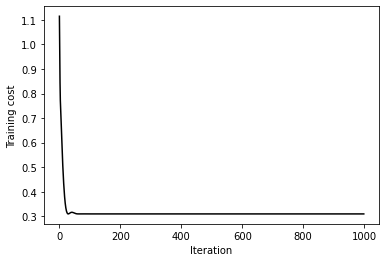

In [396]:
plt.figure()
plt.plot(cost_cache,c='k')
plt.xlabel('Iteration')
plt.ylabel('Training cost')

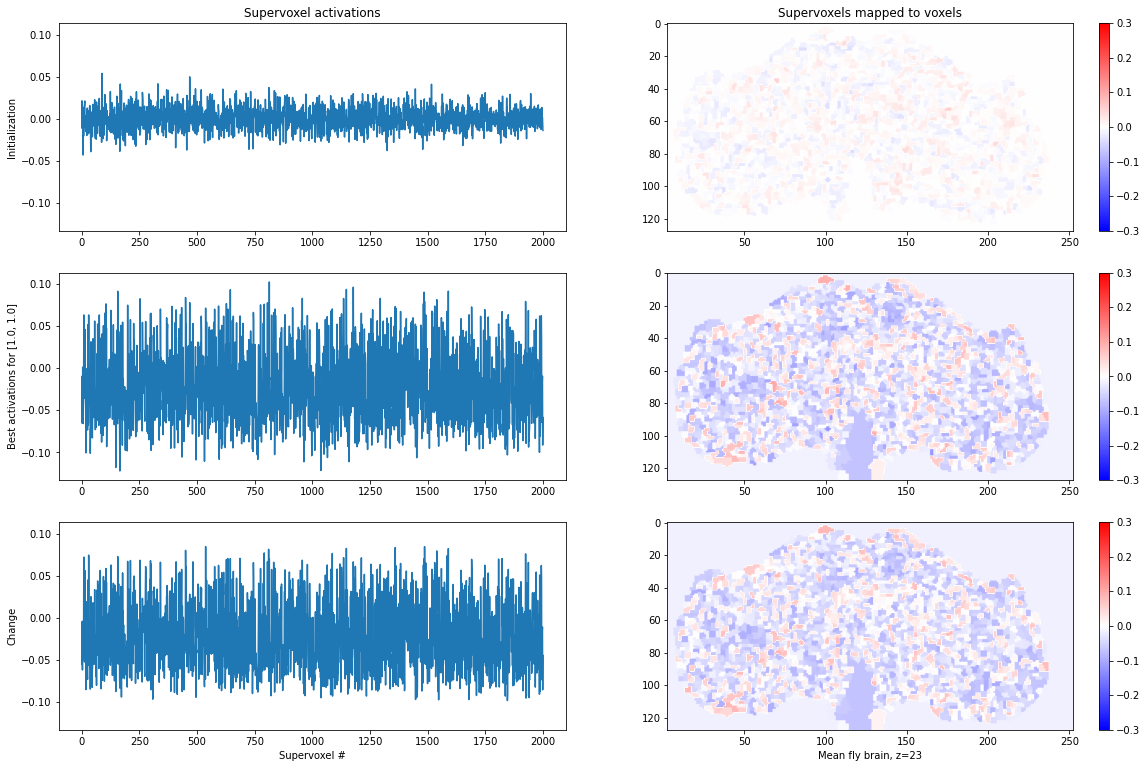

In [397]:
fig,axs = plt.subplots(3, 2, sharey='col', figsize=(20,13))

axs[0,0].plot(input_sv_np)
axs[0,0].set_title('Supervoxel activations')
axs[0,0].set_ylabel('Initialization')
axs[1,0].plot(super_sv_np)
axs[1,0].set_ylabel('Best activations for ' + str(target_y))
axs[2,0].plot(diff_sv_np)
axs[2,0].set_ylabel('Change')
axs[2,0].set_xlabel('Supervoxel #')

_,imshow0 = paint_supervoxels_to_voxels_1_z_layer(input_sv_np, cluster_labels, vmax=0.3, ax=axs[0,1])
axs[0,1].set_title('Supervoxels mapped to voxels')
_,imshow1 = paint_supervoxels_to_voxels_1_z_layer(super_sv_np, cluster_labels, vmax=0.3, ax=axs[1,1])
_,imshow2 = paint_supervoxels_to_voxels_1_z_layer( diff_sv_np, cluster_labels, vmax=0.3, ax=axs[2,1])
axs[2,1].set_xlabel('Mean fly brain, z=23')

fig.colorbar(imshow0, ax=axs[0,1])
fig.colorbar(imshow1, ax=axs[1,1])
fig.colorbar(imshow2, ax=axs[2,1])

fig.set_facecolor('white')
fig.show()

Text(0.5, 1.0, 'Change')

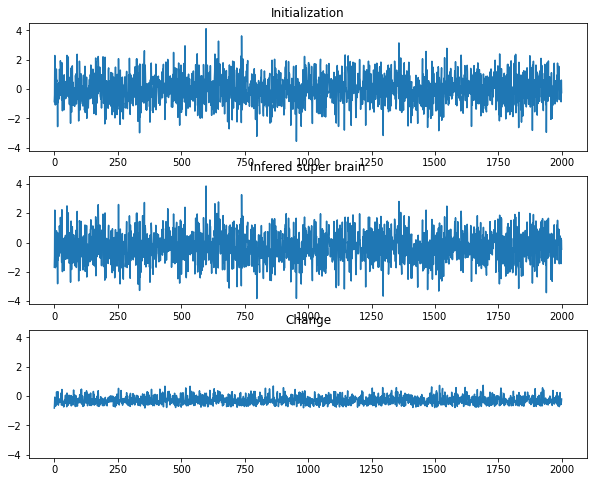

In [230]:
fig,ax = plt.subplots(3,1,sharey=True, figsize=(10,8))
ax[0].plot(input_sv_np)
ax[0].set_title('Initialization')
ax[1].plot(super_sv_np)
ax[1].set_title('Infered super brain')
ax[2].plot(diff_sv_np)
ax[2].set_title('Change')

## Convert supervoxel activity to voxel activity

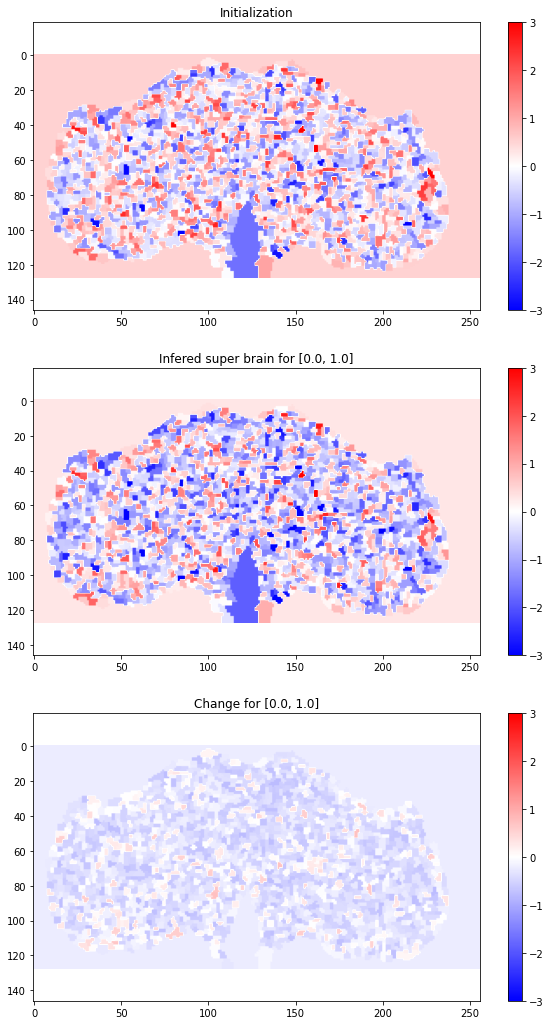

In [237]:
fig,axs = plt.subplots(3,1,figsize=(10,18))
_,imshow0 = paint_supervoxels_to_voxels_1_z_layer(input_sv_np, cluster_labels, vmax=3, ax=axs[0])
axs[0].set_title('Initialization')
_,imshow1 = paint_supervoxels_to_voxels_1_z_layer(super_sv_np, cluster_labels, vmax=3, ax=axs[1])
axs[1].set_title('Infered super brain for ' + str(target_y))
_,imshow2 = paint_supervoxels_to_voxels_1_z_layer( diff_sv_np, cluster_labels, vmax=3, ax=axs[2])
axs[2].set_title('Change for ' + str(target_y))

fig.colorbar(imshow0, ax=axs[0])
fig.colorbar(imshow1, ax=axs[1])
fig.colorbar(imshow2, ax=axs[2])

fig.show()